In [1]:
# import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# import open3d as o3d
# import laspy
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from sklearn.cluster import DBSCAN

In [2]:
# PointNet Model
class PointNetEncoder(nn.Module):
    def __init__(self, input_dim=3, emb_dim=128):
        super(PointNetEncoder, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, emb_dim, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(emb_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Convert to (B, C, N)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        global_feature = torch.max(x, 2, keepdim=True)[0]
        global_feature = global_feature.repeat(1, 1, x.shape[2])
        x = torch.cat([x, global_feature], dim=1)
        return x.permute(0, 2, 1)  # Back to (B, N, C)

In [3]:
# UNet Model
class UNetDecoder(nn.Module):
    def __init__(self, emb_dim=128, output_dim=64):
        super(UNetDecoder, self).__init__()
        self.conv1 = nn.Conv1d(emb_dim * 2, 128, 1)
        self.conv2 = nn.Conv1d(128, 64, 1)
        self.conv3 = nn.Conv1d(64, output_dim, 1)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(output_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Convert to (B, C, N)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return x.permute(0, 2, 1)  # Back to (B, N, C)

In [4]:
# PointNet-UNet Model
class PointUNet(nn.Module):
    def __init__(self, input_dim=3, emb_dim=128, output_dim=64):
        super(PointUNet, self).__init__()
        self.encoder = PointNetEncoder(input_dim, emb_dim)
        self.decoder = UNetDecoder(emb_dim, output_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
"""
Cluster Contrastive Loss
Ensures same-face points are close, different faces are separated.
"""
# Contrastive Loss
def contrastive_loss(embeddings, labels, margin=1.0):
    """
    Contrastive loss to cluster points of the same roof face and separate different faces.
    """
    batch_size, num_points, emb_dim = embeddings.shape
    loss = 0.0
    count = 0

    for i in range(batch_size):
        for j in range(num_points):
            for k in range(num_points):
                if j == k:
                    continue
                d = torch.norm(embeddings[i, j] - embeddings[i, k], p=2)
                if labels[i, j] == labels[i, k]:  # Same face
                    loss += d ** 2
                else:  # Different faces
                    loss += max(0, margin - d) ** 2
                count += 1

    return loss / count

In [6]:
# Train PointNet-UNet model
def train_model(model, train_loader, optimizer, num_epochs=10, device='cuda', save_model=False):
    """
    Trains the PointNet-UNet model and visualizes training loss.

    Args:
        model: PointNet-UNet model.
        train_loader: DataLoader for training data.
        optimizer: Optimizer for training.
        num_epochs: Number of training epochs.
        device: 'cuda' or 'cpu'.
        save_model: Whether to save the trained model after training.

    Returns:
        loss_history: List of loss values per epoch.
    """
    model.to(device)
    model.train()
    loss_history = []

    for epoch in range(num_epochs):
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")

        for data, labels in progress_bar:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = contrastive_loss(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())  # Show live loss update

        avg_loss = total_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

    # Save model after training
    if save_model:
        torch.save(model.state_dict(), "pointnet_unet_trained.pth")
        print("Model saved successfully!")

    return loss_history

In [7]:
# Post-Processing with DBSCAN for Instance Labels
def cluster_instances(embeddings, eps=0.5, min_samples=5):
    """
    Cluster points into roof faces using DBSCAN on embedding space.
    """
    embeddings_np = embeddings.detach().cpu().numpy()
    clustered_labels = []

    for batch_emb in embeddings_np:
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(batch_emb)
        clustered_labels.append(clustering.labels_)

    return np.array(clustered_labels)

In [8]:
# Test PointNet-UNet model
def test(model, test_loader, device='cuda'):
    model.eval()
    with torch.no_grad():
        for points, _ in test_loader:
            points = points.to(device)
            embeddings = model(points)  # (B, N, output_dim)
            instance_labels = cluster_instances(embeddings)
            print("Predicted Instance Labels:", instance_labels[0])  # Print for one batch
            break

In [9]:
class LiDARPointCloudDataset(Dataset):
    def __init__(self, point_folder, label_folder, max_points=2048, mode="train"):
        """
        Args:
            point_folder (str): Path to the folder containing point cloud .txt files.
            label_folder (str): Path to the folder containing corresponding label .txt files.
            max_points (int): Maximum number of points per cloud (for subsampling or padding).
            mode (str): "train" or "test".
        """
        self.point_folder = point_folder
        self.label_folder = label_folder
        self.max_points = max_points
        self.mode = mode  # 'train' or 'test'

        # List all available point files
        self.point_files = sorted([f for f in os.listdir(point_folder) if f.endswith(".txt")])
        self.label_files = sorted([f for f in os.listdir(label_folder) if f.endswith(".txt")])

        # Ensure matching point and label files
        assert len(self.point_files) == len(self.label_files), "Mismatch in points and labels count."

    def load_txt_file(self, file_path, num_features=3):
        """
        Loads a .txt file, converting string lines into a NumPy array of type float64.
        Assumes space/comma-separated values.
        """
        data = []
        with open(file_path, "r") as file:
            for line in file:
                try:
                    values = np.array(line.strip().replace(',', ' ').split(), dtype=np.float64)
                    if len(values) == num_features:
                        data.append(values)
                except ValueError:
                    continue  # Skip lines that cannot be converted

        return np.array(data)

    def load_point_cloud(self, file_path):
        """Loads point cloud (XYZ) from a .txt file and returns a NumPy array."""
        return self.load_txt_file(file_path, num_features=3)  # Expecting [x, y, z]

    def load_labels(self, file_path, num_points):
        """Loads labels from a .txt file, ensuring it matches the number of points."""
        labels = self.load_txt_file(file_path, num_features=1).flatten()
        if len(labels) != num_points:
            print(f"Warning: {file_path} has {len(labels)} labels, expected {num_points}. Using zero-padding.")
            labels = np.pad(labels, (0, max(0, num_points - len(labels))), 'constant', constant_values=0)
        return labels

    def pad_or_subsample(self, points, labels):
        """Ensures a fixed number of points per cloud using padding or subsampling."""
        num_points = points.shape[0]

        if num_points > self.max_points:
            # Randomly sample points
            indices = np.random.choice(num_points, self.max_points, replace=False)
            points, labels = points[indices], labels[indices]
        elif num_points < self.max_points:
            # Pad with zeros
            pad_size = self.max_points - num_points
            pad_points = np.zeros((pad_size, 3), dtype=np.float64)
            pad_labels = np.zeros(pad_size, dtype=np.int64)
            points = np.vstack((points, pad_points))
            labels = np.hstack((labels, pad_labels))

        return points, labels

    def __len__(self):
        return len(self.point_files)

    def __getitem__(self, idx):
        point_path = os.path.join(self.point_folder, self.point_files[idx])
        label_path = os.path.join(self.label_folder, self.label_files[idx])

        point_cloud = self.load_point_cloud(point_path)
        labels = self.load_labels(label_path, num_points=point_cloud.shape[0])

        # Apply padding or subsampling
        point_cloud, labels = self.pad_or_subsample(point_cloud, labels)

        return torch.tensor(point_cloud, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)

In [10]:
# Dynamic Batching with Collate Function
def collate_fn(batch):
    """
    Custom collate function to handle variable-length point clouds.
    Stacks padded point clouds into a batch.
    """
    point_clouds, labels = zip(*batch)

    # Convert to PyTorch tensors
    point_clouds = torch.stack(point_clouds)  # (batch_size, max_points, 3)
    labels = torch.stack(labels)  # (batch_size, max_points)

    return point_clouds, labels

In [13]:
# Define dataset paths
points_folder = "data/sample_points_50"
labels_folder = "data/sample_labels_50"

# Create dataset instance
train_dataset = LiDARPointCloudDataset(points_folder, labels_folder, max_points=128, mode="train")

# Create DataLoader
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

train_loader = DataLoader(
    train_dataset, batch_size=4, shuffle=True,
    num_workers=4,  # Use multiple CPU cores for faster loading
    pin_memory=True,  # Optimizes GPU transfers
    collate_fn=collate_fn
)

# Check batch
for points, labels in train_loader:
    print("Batch Point Cloud Shape:", points.shape)  # Expected: (batch_size, max_points, 3)
    print("Batch Labels Shape:", labels.shape)  # Expected: (batch_size, max_points)
    break

FileNotFoundError: [Errno 2] No such file or directory: 'data/sample_points_50'

In [11]:
def visualize_lidar_with_plotly(points, labels, scatter_size=1):
    """
    Visualizes a LiDAR point cloud with color-coded segmentation labels using Plotly.

    Args:
        points (numpy array): Shape (N, 3) - XYZ coordinates.
        labels (numpy array): Shape (N,) - Segmentation labels.
    """
    # Convert points and labels into a Pandas DataFrame
    df = pd.DataFrame({
        "X": points[:, 0],
        "Y": points[:, 1],
        "Z": points[:, 2],
        "Label": labels
    })

    # Create 3D scatter plot
    fig = px.scatter_3d(
        df, x="X", y="Y", z="Z",
        color=df["Label"].astype(str),  # Color by label
        title="3D LiDAR Point Cloud Segmentation",
        labels={"Label": "Segmentation Label"},
        opacity=0.7
    )

    # Update marker size
    fig.update_traces(marker=dict(size=scatter_size))

    # Hide XYZ planes, grids, and background
    fig.update_layout(
        scene=dict(
            xaxis=dict(visible=False),  # Hide X-axis
            yaxis=dict(visible=False),  # Hide Y-axis
            zaxis=dict(visible=False),  # Hide Z-axis
            bgcolor="rgba(0,0,0,0)"  # Transparent background
        ),
        margin=dict(l=0, r=0, b=0, t=40),  # Reduce margin for better display
        legend=dict(
            title="Segmentation Label",  # Ensure correct legend title
            x=0.02,  # Move legend closer to the points
            y=0.98
        )
    )

    # Show figure
    fig.show()

In [12]:
# Get a batch from DataLoader
for points, labels in train_loader:
    points_np = points[0].cpu().numpy()  # Convert first point cloud in batch to NumPy
    labels_np = labels[0].cpu().numpy()  # Convert first label set in batch to NumPy
    visualize_lidar_with_plotly(points_np, labels_np, scatter_size=4)  # Show visualization
    break  # Only visualize one batch

NameError: name 'train_loader' is not defined

Using device: cuda


Epoch 1/10: 100%|██████████| 13/13 [04:39<00:00, 21.48s/it, loss=12.9]


Epoch 1/10, Loss: 7.8373


Epoch 2/10: 100%|██████████| 13/13 [04:54<00:00, 22.68s/it, loss=7.56] 


Epoch 2/10, Loss: 2.7162


Epoch 3/10: 100%|██████████| 13/13 [04:50<00:00, 22.37s/it, loss=0.811]


Epoch 3/10, Loss: 1.2486


Epoch 4/10: 100%|██████████| 13/13 [05:18<00:00, 24.54s/it, loss=1.39] 


Epoch 4/10, Loss: 0.7412


Epoch 5/10: 100%|██████████| 13/13 [06:01<00:00, 27.80s/it, loss=1.92] 


Epoch 5/10, Loss: 0.5260


Epoch 6/10: 100%|██████████| 13/13 [06:49<00:00, 31.47s/it, loss=0.418]


Epoch 6/10, Loss: 0.2855


Epoch 7/10: 100%|██████████| 13/13 [06:46<00:00, 31.24s/it, loss=1.7]  


Epoch 7/10, Loss: 0.3450


Epoch 8/10: 100%|██████████| 13/13 [06:13<00:00, 28.74s/it, loss=0.959]


Epoch 8/10, Loss: 0.3509


Epoch 9/10: 100%|██████████| 13/13 [06:32<00:00, 30.16s/it, loss=0.213]


Epoch 9/10, Loss: 0.2298


Epoch 10/10: 100%|██████████| 13/13 [07:06<00:00, 32.84s/it, loss=0.267]


Epoch 10/10, Loss: 0.1926


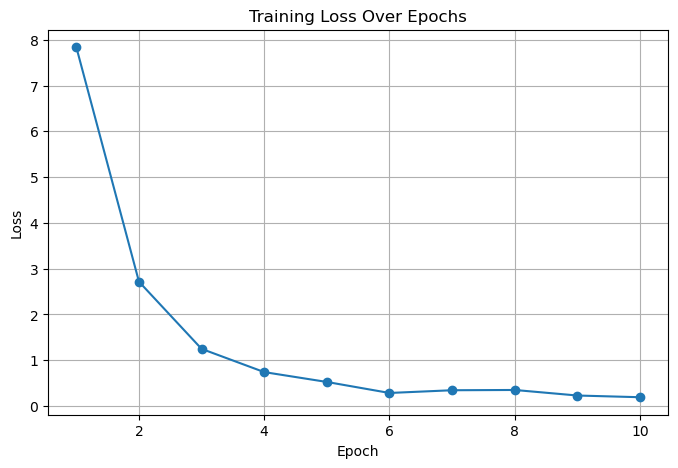

In [27]:
# Initialize model & optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print("Using device:", device)
model = PointUNet(input_dim=3, emb_dim=128, output_dim=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Train and visualize loss
loss_history = train_model(model, train_loader, optimizer, num_epochs=10, device=device, save_model=False)

# Plot loss curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid()
plt.show()

In [52]:
def inference_on_point_cloud(model, point_cloud, device='cuda', eps=0.5, min_samples=3, scatter_size=3):
    """
    Runs inference on a single point cloud and visualizes predictions in real-time.
    
    Args:
        model: Trained Point-U-Net model.
        point_cloud: Input point cloud (numpy array of shape (N, 3)).
        device: 'cuda' or 'cpu' for inference.
        eps: DBSCAN clustering epsilon (distance threshold).
        min_samples: Minimum points in a cluster for DBSCAN.
        scatter_size: Size of scatter points in visualization.
    """
    model.eval()
    point_cloud_tensor = torch.tensor(point_cloud, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        embeddings = model(point_cloud_tensor).squeeze(0).cpu().numpy()  # Run inference

    # Normalize embeddings before DBSCAN
    # embeddings = StandardScaler().fit_transform(embeddings)

    # Apply DBSCAN clustering
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(embeddings)
    predicted_labels = clustering.labels_

    # Prepare data for visualization
    df = pd.DataFrame({
        "X": point_cloud[:, 0],
        "Y": point_cloud[:, 1],
        "Z": point_cloud[:, 2],
        "Predicted Instance": predicted_labels.astype(str)  # Convert labels to string for coloring
    })

    # Create 3D scatter plot
    fig = px.scatter_3d(
        df, x="X", y="Y", z="Z",
        color="Predicted Instance",
        title="Real-Time Roof Segmentation",
        opacity=1.0
    )

    # Update marker size for better visibility
    fig.update_traces(marker=dict(size=scatter_size))

    # Hide XYZ planes, grids, and background
    fig.update_layout(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False),
            bgcolor="rgba(0,0,0,0)"
        ),
        margin=dict(l=0, r=0, b=0, t=40),
        legend=dict(
            title="Segmentation Label",
            x=0.2,  # Moves legend closer to the points
            y=0.90,
            font=dict(size=12)  # Adjust legend font size
        )
    )

    fig.show()

In [18]:
def load_clean_point_cloud(file_path, max_points=128):
    """
    Reads a point cloud file, removes non-numeric lines, and ensures exactly 128 points.
    
    Args:
        file_path (str): Path to the .txt file containing point cloud data.
        max_points (int): Fixed number of points per cloud (default: 128).
    
    Returns:
        numpy array: (128, 3) shape point cloud with valid XYZ values.
    """
    valid_points = []

    with open(file_path, "r") as file:
        for line in file:
            try:
                # Convert to float, handling both spaces & commas as delimiters
                values = np.array(line.strip().replace(',', ' ').split(), dtype=np.float64)
                if len(values) == 3:  # Ensure it's an (X, Y, Z) point
                    valid_points.append(values)
            except ValueError:
                continue  # Skip invalid lines

    valid_points = np.array(valid_points)

    num_points = valid_points.shape[0]

    if num_points > max_points:
        # Subsample to 128 points randomly
        indices = np.random.choice(num_points, max_points, replace=False)
        valid_points = valid_points[indices]
    elif num_points < max_points:
        # Pad with zeros to reach 128 points
        pad_size = max_points - num_points
        pad_points = np.zeros((pad_size, 3), dtype=np.float64)
        valid_points = np.vstack((valid_points, pad_points))

    return valid_points

In [29]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
model = PointUNet(input_dim=3, emb_dim=128, output_dim=64).to(device)

# Load trained weights
model.load_state_dict(torch.load("model/pointnet_unet_checkpoint.pth", map_location=device))
model.eval()  # Set model to evaluation mode
print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [53]:
# model.eval()

# Load a test point cloud
test_point_cloud = load_clean_point_cloud("data/points/94939.txt")  # Assuming XYZ format

# Run real-time inference & visualization
inference_on_point_cloud(model, test_point_cloud, device, eps=0.18, min_samples=3)

In [43]:
torch.save(model.state_dict(), "model/pointnet_unet_checkpoint.pth")
print("Model checkpoint saved!")

Model checkpoint saved!
